In [329]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
import itertools
import seaborn as sns

In [145]:
with open("adult.data.txt") as f: 
    adult_data = f.readlines()
colnames = ["age", "workclass", "fnlwgt", "education", "education-num", 
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week", "native-country","50k"]
data = [colnames]
for i in range(len(adult_data)):
    data.append(adult_data[i][:-1].split(", "))
data = pd.DataFrame(data[1:],columns=data[0])
data = data.dropna()
categorical = ["workclass","education","marital-status","occupation","relationship", "race", "sex","native-country","50k"]
continuous = ["age", "fnlwgt", "education-num","capital-gain", "capital-loss", "hours-per-week"]

data[categorical] = data[categorical].astype('category')
data[continuous] = data[continuous].astype("float")

In [264]:
np.sum(data["50k"] == "<=50K")/data.shape[0]

0.7591904425539756

## Visualization 1 

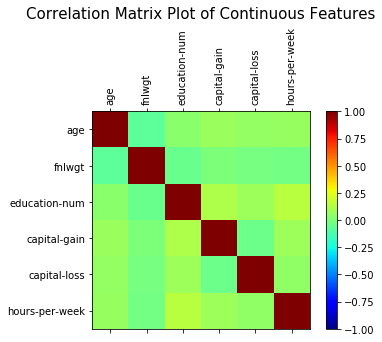

In [107]:
correlations = data[continuous].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap='jet')
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(continuous, rotation=90)
ax.set_yticklabels(continuous)
plt.title("Correlation Matrix Plot of Continuous Features", y=1.4, size = 15)
plt.show()


The correlation matrix encodes data by 2D matrix(area mark) and color saturation channel, the task is to find correlation among features(VAD p186,p188). The plot is clear and no redundant information is included. From the correlation plot above, we can see the features are not highly correlated with each other, which means we can skip multicollinearity removal step.

## Visualization 2

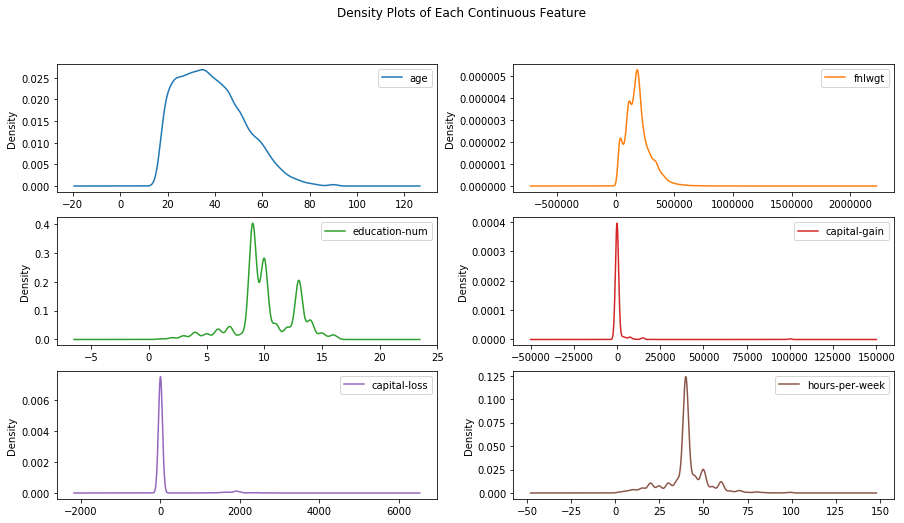

In [130]:
data[continuous].plot(kind='density', subplots=True, layout=(3,2), sharex = False,
                      figsize = (15,8), title = "Density Plots of Each Continuous Feature")
plt.show()

The task is to visualize the overall distribution of each continuous feature. Each density distribution plot encode on quantitative value attribute by line mark with aligned postion to express the quantitative value(VAD P33), which is very effective.
The distributions of all continuous features are close to bell shape, which is perfect for regression models.

### Data Preprocessing

In [229]:
data_x = pd.concat([data[continuous], pd.get_dummies(data[categorical])], axis = 1)
data_x = data_x.drop('50k_<=50K', axis = 1).rename(columns = {'50k_>50K':"50k"})
data_y = data_x["50k"]
data_x = data_x.drop("50k", axis = 1)

# train test split & reset index
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
train_x = train_x.reset_index(drop = True)
train_y = train_y.reset_index(drop = True)
test_x = test_x.reset_index(drop = True)
test_y = test_y.reset_index(drop = True)

# Standardization
scaler = preprocessing.StandardScaler().fit(train_x[continuous])
train_x[continuous] = scaler.transform(train_x[continuous])
test_x[continuous] = scaler.transform(test_x[continuous])


1. Standardize continuous features in the train set and use the scaler to transform test set. Otherwise, features measured at different scales do not contribute equally to the analysis. And a model shall be applied on unseen data which is not available at the time the model is built. If we normalize all data point at first, test set may contain information from train set. 

2. One hot encode all categorical features and convert the output variable "50k" in 0-1. KNN cannot operate on categorical data directly, so the categorical data must be converted to a numerical form. 

### KNN

In [249]:
tune = [list(range(1,11)), [1,2]]
tune = list(itertools.product(*tune))
scores = []
for item in tune:
    KNN = KNeighborsClassifier(n_neighbors=item[0], p = item[1])
    score = cross_validate(KNN, train_x.values, train_y, scoring="f1", cv=10, return_train_score=False)
    scores.append(score["test_score"])

In [300]:
Dict = {"N" : np.concatenate([[str(i)] *20 for i in range(1,11)]), 
        "P" : np.concatenate([[str(1)] *10 + [str(2)] *10 for i in range(1,11)]),
        "F1" : np.concatenate(scores)}
frame = pd.DataFrame(Dict)

### Visualization 3

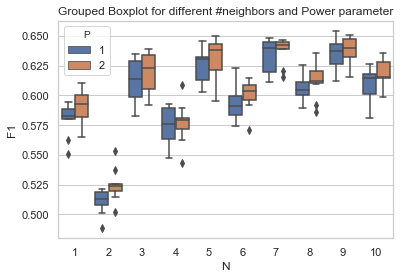

In [320]:
sns.set(style="whitegrid")
sns.boxplot(x="N", y="F1", hue="P", data = frame, 
           order=[str(i) for i in range(1,11)])
plt.title("Grouped Boxplot for different #neighbors and Power parameter")
plt.show()

Boxplot encode data by creating one glyph per original attribute expressing derived attribute values using vertical spatial position, with 1D list alignment of glyphs into separated with hori- zontal spatial position(VAD P309, 310). Each boxplot requires only a very small amount of screen space along the secondary axis. Furthermore, Boxplots directly show not only the mean values but also the spread of F1 scores for each pair of parameters. 

### Test set performance

In [324]:
np.argmax(np.mean(scores, axis= 1)) + 1

14

In [327]:
best_params = [7,2]
KNN_best = KNeighborsClassifier(n_neighbors=best_params[0], p = best_params[1])
KNN_best.fit(train_x.values,train_y.values)
preds = KNN_best.predict(test_x.values)

In [338]:
print("F1 Score on Test Set: %f"% f1_score(preds, test_y.values))

F1 Score on Test Set: 0.644723
